In [42]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import missingno as msno
import matplotlib.pyplot as plt
from datetime import date
today = date.today()
from tqdm import tqdm
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [136]:
#Lecture du Fichier
df = pd.read_csv('QueryResults.csv', sep = ',', encoding='UTF-8')

#Lecture du Fichier de tags
#df_tags1 = pd.read_csv('Tags1.csv', sep = ',', encoding='UTF-8')
#df_tags2 = pd.read_csv('Tags2.csv', sep = ',', encoding='UTF-8')

#df_tags_full = pd.concat([df_tags1, df_tags2], axis=0)



In [5]:
df.shape

(16413, 5)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16413 entries, 0 to 16412
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Id            16413 non-null  int64 
 1   BODY          16413 non-null  object
 2   Title         16413 non-null  object
 3   Tags          16413 non-null  object
 4   CreationDate  16413 non-null  object
dtypes: int64(1), object(4)
memory usage: 641.3+ KB


In [7]:
df.isna().mean()

Id              0.0
BODY            0.0
Title           0.0
Tags            0.0
CreationDate    0.0
dtype: float64

In [17]:
#Téléchargement des packages nltk
nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

# Traitement du champs Tags
* On détermine les 100 Tags les plus utlisés
* On supprime tous les Tags qui ne font pas partis de ce TOP 100
* Supression des lignes Tags

## Première méthode avec le CountVectorizer

In [112]:
# Processing tags
df["Tags"] = df["Tags"].replace({"<" : " "},
                                     regex=True)
df["Tags"] = df["Tags"].replace({">" : ","},
                                     regex=True)
df["Tags"] = df["Tags"].str.rstrip(',')

In [113]:
vectorizer = CountVectorizer(max_features=100)
bow_tags = vectorizer.fit_transform(df["Tags"]).toarray()
df_tags = pd.DataFrame(bow_tags, columns=vectorizer.get_feature_names_out())
df_tags = pd.DataFrame(df_tags.sum(), columns=["Value"])

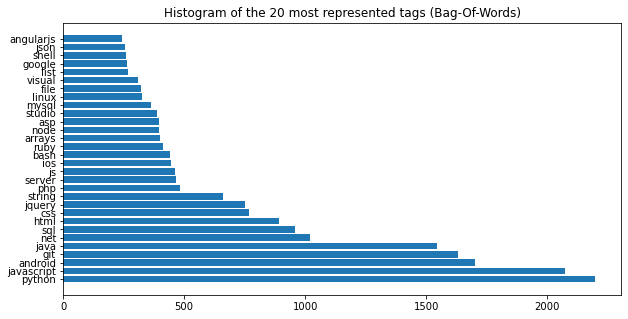

In [114]:
top_20_tags_word = df_tags.sort_values("Value", ascending=False)[:30]

plt.figure(figsize=(10,5))
plt.barh(y=top_20_tags_word.index, width=top_20_tags_word.Value)
plt.title("Histogram of the 20 most represented tags (Bag-Of-Words)")
plt.show()

In [115]:
tags_more_frequent = df_tags.loc[df_tags["Value"] >= 150].sort_values("Value", ascending=False).index.tolist()

In [116]:
tags_only = df["Tags"].str.split(",", expand=True)
df = pd.merge(df, tags_only,left_index=True,right_index=True)
df.columns = ["Id", "Title", "Body", "Tags", "CreationDate","Tags_1", "Tags_2", "Tags_3", "Tags_4", "Tags_5"]

In [120]:
tags = ["Tags_1", "Tags_2", "Tags_3", "Tags_4", "Tags_5"]

for i in tags_more_frequent:
    for j in tags:
        more_frequent = df.loc[df[j].str.contains(i, na=True)]
        
more_frequent.drop(["Tags_1", "Tags_2", "Tags_3", "Tags_4", "Tags_5"], axis=1, inplace=True)

C:\Users\jerom\anaconda3\envs\PROJET5\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


## Deuxième méthode avec le TOKENIZER et l'expression régulière

In [137]:
#Expression régulière pour prendre uniquement les valeurs entre <>
tokenizer = RegexpTokenizer('(?<=\<).*?(?=\>)')

#Création de la colonne avec ces valeurs
df['tags_words'] = df.apply(lambda row: tokenizer.tokenize(row['Tags']), axis=1)

#Comptage de l'utlisation des mots
Top_Word = nltk.FreqDist()
Top100 = []
for x in df['tags_words']:
    Top_Word += nltk.FreqDist(x)

for i in Top_Word.most_common()[0:100]:
    Top100.append(i[0])

In [138]:
#Fonction qui supprime le tag si celui ci n'appartient au TOP        
def removeNotTop100(Word_list):
    filtered_Word_list = Word_list[:] #make a copy of the Word_list
    for Word in Word_list: # iterate over Word_list
        if Word not in Top100: 
            filtered_Word_list.remove(Word) # remove Word from filtered_Word_list if it is a stopword
    if len(filtered_Word_list) == 0:
        return None
    else:
        return filtered_Word_list

In [139]:
#Suppression des Tags qui ne sont pas dans le TOP
df['processed_tags_final'] = df.apply(lambda row:removeNotTop100(row['tags_words']), axis=1)

In [140]:
#Suppression des lignes sans Tags
df = df.dropna()

In [142]:
df.head(10)

,Id,BODY,Title,Tags,CreationDate,tags_words,processed_tags_final
0,12051,<p>If I inherit from a base class and want to ...,Calling the base constructor in C#,<c#><.net><inheritance><constructor>,2008-08-15 07:39:23,"[c#, .net, inheritance, constructor]","[c#, .net]"
1,17319422,<p>I am using PyCharm on Windows and want to c...,How do I set the maximum line length in PyCharm?,<python><pycharm><pep8>,2013-06-26 12:00:31,"[python, pycharm, pep8]",[python]
2,32664,<p>Can anyone tell me if there is a way with g...,Is there a constraint that restricts my generi...,<c#><generics><constraints>,2008-08-28 16:04:49,"[c#, generics, constraints]","[c#, generics]"
3,8763125,<p>I would like to get the keys of a JavaScrip...,Get array of object's keys,<javascript><ecmascript-5>,2012-01-06 19:12:38,"[javascript, ecmascript-5]",[javascript]
5,33923,"<p>Whilst starting to learn lisp, I've come ac...",What is tail recursion?,<algorithm><language-agnostic><functional-prog...,2008-08-29 03:48:03,"[algorithm, language-agnostic, functional-prog...","[algorithm, language-agnostic]"
6,33969,<p>We're experimenting with various ways to th...,Best way to implement request throttling in AS...,<asp.net-mvc><throttling>,2008-08-29 04:50:50,"[asp.net-mvc, throttling]",[asp.net-mvc]
7,33978,<p>How would you go about finding out how much...,Find out how much memory is being used by an o...,<python><performance><memory-profiling>,2008-08-29 04:59:31,"[python, performance, memory-profiling]","[python, performance]"
8,33207,<p>What frameworks exist to unit test Objectiv...,What is the best way to unit test Objective-C ...,<objective-c><cocoa><unit-testing><xcode>,2008-08-28 19:41:30,"[objective-c, cocoa, unit-testing, xcode]","[objective-c, unit-testing, xcode]"
9,32899,<p>I have some kind of test data and want to c...,How do you generate dynamic (parameterized) un...,<python><unit-testing><parameterized-unit-test>,2008-08-28 17:49:02,"[python, unit-testing, parameterized-unit-test]","[python, unit-testing]"
10,33746,<p>At work we are being asked to create XML fi...,XML attribute vs XML element,<xml><xsd>,2008-08-29 01:15:52,"[xml, xsd]",[xml]


## Affichage d'un WORDCLOUD sur la feature TAGS

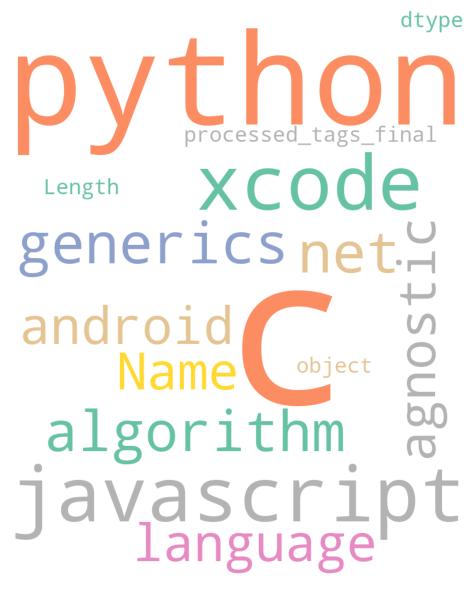

In [18]:
from wordcloud import WordCloud
wordcloud = WordCloud(width = 800, height = 1000,
                max_words=1000,
                background_color ='white',
                min_font_size = 12,
                colormap="Set2").generate(str(df['processed_tags_final']))
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

# Préprocesing du champs BODY
* Utilisation de BEAUTIFULSOUP pour le traitement HTML
* Puis remplacement des retours chariots et des :
* Création du nuage de mots
* Supression des StopWord Anglais

In [49]:
#Préprocessing du champ BODY
df['processed_body'] = df['BODY'].map(lambda x: BeautifulSoup(x, "html.parser").get_text())
df['processed_body'] = df['processed_body'].map(lambda x: x.replace('\n', ' '))
df['processed_body'] = df['processed_body'].map(lambda x: x.replace(':', ''))

#Création des nuages de mots avec NLTK
df['processed_body2'] = df.apply(lambda row: nltk.word_tokenize(row['processed_body'],language='english'), axis=1)

#Supression des StopWord
df['processed_body_final'] = df.apply(lambda row:removeStopWord(row['processed_body2']), axis=1)

In [50]:
df.head(2)

,Id,BODY,Title,Tags,CreationDate,processed_body,processed_body2,processed_body_final
0,12051,<p>If I inherit from a base class and want to ...,Calling the base constructor in C#,<c#><.net><inheritance><constructor>,2008-08-15 07:39:23,If I inherit from a base class and want to pas...,"[If, I, inherit, from, a, base, class, and, wa...","[inherit, base, class, want, pass, something, ..."
1,17319422,<p>I am using PyCharm on Windows and want to c...,How do I set the maximum line length in PyCharm?,<python><pycharm><pep8>,2013-06-26 12:00:31,I am using PyCharm on Windows and want to chan...,"[I, am, using, PyCharm, on, Windows, and, want...","[using, PyCharm, Windows, want, change, settin..."


# Fonction de suppression des StopWords Anglais

In [31]:
stop_words = set(stopwords.words('English'))
def removeStopWord(Word_list):
    filtered_Word_list = Word_list[:] #make a copy of the Word_list
    for Word in Word_list: # iterate over Word_list
        if Word.lower() in stop_words: 
            filtered_Word_list.remove(Word) # remove Word from filtered_Word_list if it is a stopword
    return filtered_Word_list

# Préprocesing du champs Titre

* Remplacement des retours chariots et des :
* Création du nuage de mots
* Supression des StopWord Anglais

In [245]:
#Préprocessing du champ Title
df['processed_title'] = df['Title'].map(lambda x: x.replace('\n', ' '))
df['processed_title'] = df['processed_title'].map(lambda x: x.replace(':', ''))

#Création des nuages de mots avec NLTK
df['processed_title2'] = df.apply(lambda row: nltk.word_tokenize(row['processed_title'],language='english'), axis=1)

#Supression des StopWord
df['processed_title_final'] = df.apply(lambda row:removeStopWord(row['processed_title2']), axis=1)

In [248]:
#Suppression des colonnes inutiles
df.drop({'processed_body','processed_body2','tags_words','processed_title','processed_title2'}, axis=1, inplace=True)

In [295]:
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()
def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in text]

In [296]:
from nltk.stem.wordnet import WordNetLemmatizer
#lemmatisation
df['processed_title_final2'] = df.apply(lambda row:lemmatize_text(row['processed_title_final']), axis=1)


In [297]:
df.head(10)

,Id,BODY,Title,Tags,CreationDate,processed_body_final,processed_tags_final,processed_title_final,processed_title_final2,processed_body_final2
0,12051,<p>If I inherit from a base class and want to ...,Calling the base constructor in C#,<c#><.net><inheritance><constructor>,2008-08-15 07:39:23,"[inherit, base, class, want, pass, something, ...","[c#, .net]","[Calling, base, constructor, C, #]","[Calling, base, constructor, C, #]",<WordNetLemmatizer>
1,17319422,<p>I am using PyCharm on Windows and want to c...,How do I set the maximum line length in PyCharm?,<python><pycharm><pep8>,2013-06-26 12:00:31,"[using, PyCharm, Windows, want, change, settin...",[python],"[set, maximum, line, length, PyCharm, ?]","[set, maximum, line, length, PyCharm, ?]",<WordNetLemmatizer>
2,32664,<p>Can anyone tell me if there is a way with g...,Is there a constraint that restricts my generi...,<c#><generics><constraints>,2008-08-28 16:04:49,"[anyone, tell, way, generics, limit, generic, ...","[c#, generics]","[constraint, restricts, generic, method, numer...","[constraint, restricts, generic, method, numer...",<WordNetLemmatizer>
3,8763125,<p>I would like to get the keys of a JavaScrip...,Get array of object's keys,<javascript><ecmascript-5>,2012-01-06 19:12:38,"[would, like, get, keys, JavaScript, object, a...",[javascript],"[Get, array, object, 's, keys]","[Get, array, object, 's, key]",<WordNetLemmatizer>
5,33923,"<p>Whilst starting to learn lisp, I've come ac...",What is tail recursion?,<algorithm><language-agnostic><functional-prog...,2008-08-29 03:48:03,"[Whilst, starting, learn, lisp, ,, 've, come, ...","[algorithm, language-agnostic]","[tail, recursion, ?]","[tail, recursion, ?]",<WordNetLemmatizer>
6,33969,<p>We're experimenting with various ways to th...,Best way to implement request throttling in AS...,<asp.net-mvc><throttling>,2008-08-29 04:50:50,"['re, experimenting, various, ways, throttle, ...",[asp.net-mvc],"[Best, way, implement, request, throttling, AS...","[Best, way, implement, request, throttling, AS...",<WordNetLemmatizer>
7,33978,<p>How would you go about finding out how much...,Find out how much memory is being used by an o...,<python><performance><memory-profiling>,2008-08-29 04:59:31,"[would, go, finding, much, memory, used, objec...","[python, performance]","[Find, much, memory, used, object, Python]","[Find, much, memory, used, object, Python]",<WordNetLemmatizer>
8,33207,<p>What frameworks exist to unit test Objectiv...,What is the best way to unit test Objective-C ...,<objective-c><cocoa><unit-testing><xcode>,2008-08-28 19:41:30,"[frameworks, exist, unit, test, Objective-C, c...","[objective-c, unit-testing, xcode]","[best, way, unit, test, Objective-C, code, ?]","[best, way, unit, test, Objective-C, code, ?]",<WordNetLemmatizer>
9,32899,<p>I have some kind of test data and want to c...,How do you generate dynamic (parameterized) un...,<python><unit-testing><parameterized-unit-test>,2008-08-28 17:49:02,"[kind, test, data, want, create, unit, test, i...","[python, unit-testing]","[generate, dynamic, (, parameterized, ), unit,...","[generate, dynamic, (, parameterized, ), unit,...",<WordNetLemmatizer>
10,33746,<p>At work we are being asked to create XML fi...,XML attribute vs XML element,<xml><xsd>,2008-08-29 01:15:52,"[work, asked, create, XML, files, pass, data, ...",[xml],"[XML, attribute, vs, XML, element]","[XML, attribute, v, XML, element]",<WordNetLemmatizer>


# Création du jeu de test et d'entrainement

In [256]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df,test_size=0.2,random_state=42)

In [280]:
from sklearn.datasets import make_multilabel_classification
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score




mlp1 = MLPClassifier(hidden_layer_sizes=(200, ), max_iter=200, random_state=1)
mlp1.fit(df_train.loc[:,{'processed_title_final','processed_body_final'}].to_numpy(), df_train.loc[:,'processed_tags_final'].to_numpy())
y_pred1 = mlp1.predict(df_test.loc['processed_title_final','processed_body_final'].to_numpy())

#mlp2 = MLPClassifier(hidden_layer_sizes=(200, ), max_iter=200, random_state=1)
#mlp2.partial_fit(df_train.loc[:,{'processed_title_final','processed_body_final'}],df_train.loc[:,'processed_tags_final'], classes=list(range(df_train.loc[:,'processed_tags_final'].shape[1])))
#y_pred2 = mlp2.predict(x_test)

print('Using `fit`:')
print(accuracy_score(y_test, y_pred1))

#print('Using `partial_fit`:')
#print(accuracy_score(y_test, y_pred2))

ValueError: setting an array element with a sequence.

In [268]:
df_train.loc[:,'processed_tags_final'].shape[1]

IndexError: tuple index out of range

In [270]:
X, y = make_multilabel_classification(n_samples=1000, n_features=10,
                                      n_classes=5, n_labels=2,
                                      allow_unlabeled=False, random_state=1)

In [275]:
X

array([[ 2.,  6.,  2., ...,  9.,  4., 13.],
       [ 4.,  8.,  6., ...,  8.,  2.,  3.],
       [ 4.,  3.,  2., ...,  2.,  5., 11.],
       ...,
       [ 1.,  6.,  5., ..., 10.,  8., 10.],
       [ 3.,  5.,  3., ...,  3.,  3.,  5.],
       [ 7.,  6.,  1., ...,  8.,  5.,  3.]])